In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ["OMP_NUM_THREADS"] = "1"
from train import *
from train_config import load_config


In [2]:
plt.rcParams.update({'font.size': 7,
                     'font.family': 'arial',
                     'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'savefig.dpi': 480})
from matplotlib.colors import LinearSegmentedColormap
color_dict = {
    'ANTI_DM': '#2b8a3e',
    'PRO_DM': '#f59f00',
    'PRO_M': '#b30000',
    'PRO_D': '#be4bdb',
    'ANTI_M': '#364fc7',
    'ANTI_D': '#21B8CF',
    'PRO_S': '#be4bdb',
    'ANTI_S': '#21B8CF',
}

label_dict = {
    'ANTI_DM': 'DMAnti', # abbrev: Adm
    'PRO_DM': 'DMPro',  # abbrev: Pdm
    'PRO_M': 'MemoryPro', # abbrev: Pm
    'PRO_D': 'DelayPro',  # abbrev: Pd
    'ANTI_M': 'MemoryAnti',  # abbrev: Am
    'ANTI_D': 'DelayAnti',  # abbrev: Ad
    'PRO_S': 'M\'Pro', # abbrev: Ps
    'ANTI_S': 'M\'ANTI' # abbrev: As
}

### model comparison

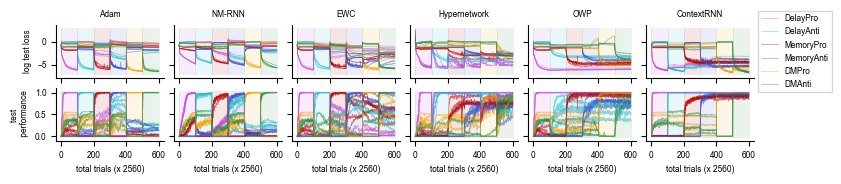

In [8]:
plt.rcParams.update({'font.size': 6,})
task_order = 'PdAdPmAmPdmAdm' # ['PdAdPmAmPdmAdm', 'PdPmAdAmPdmAdm', 'PdmAdmPdAdPmAm', 'PmPdAmAdPdmAdm']
nonlin_str = '_relu'
nonlin_save_str = '_tanh' if nonlin_str == '' else nonlin_str
model_titles = ['Adam', 'NM-RNN', 'EWC', 'Hypernetwork', 'OWP', 'ContextRNN']
n_model = len(model_titles)

fig, axes = plt.subplots(2, n_model, figsize=(1.5 * n_model, 1.5), sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1, hspace=0.2)
task_list, dn_ckpt = None, None
for i_model in range(n_model):
    for seed in range(5):
        if i_model == 0:  # 'Adam'
            save_name = f'leakyrnn_v1{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        elif i_model == 1: # NM-RNN
            save_name = f'nmrnn_rk27_nh256_nz125{nonlin_str}_{task_order}_lr0pt001_sd{seed}'
        elif i_model == 2: # 'EWC'
            save_name = f'leakyrnn_v1_ewc50000{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        elif i_model == 3: # 'Hypernetwork'
            save_name = f'hyperrnn_v1{nonlin_str}_sumbeta1_{task_order}_lr0pt001_sd{seed}'
        elif i_model == 4: # 'OrthoWeightProj'
            save_name = f'leakyrnn_v1_proj{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        else:  # 'ContextRNN'
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{task_order}_tskm512_sd{seed}'
        config = load_config(save_name)
        config['retrain'] = False
        assert config['strict'] == True
        train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
        model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
        task_list, dn_ckpt = config['task_list'], config['num_iter'] / config['ckpt_step']
        for irow in range(2):
            ts_arr = [np.log(ts_loss_arr), ts_perf_arr][irow]
            for itask, task in enumerate(config['task_list']):
                label_kwargs = {'label': label_dict[config['task_list'][itask]]} if seed == 0 else {}
                axes[irow, i_model].plot(ts_arr[itask], color=color_dict[task], alpha=0.5, 
                                         **label_kwargs, linewidth=0.5)

axes[0, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for irow in range(2):
    axes[irow, 0].set_ylabel(['log test loss', 'test \n performance'][irow])
for icol in range(n_model):
    axes[0, icol].set_title(model_titles[icol], fontsize=6)
    axes[-1, icol].set_xlabel('total trials (x 2560)')
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False)

y_rngs = []
for irow in range(2):
    y_rngs.append(axes[irow, 0].get_ylim())

dn_plot = 0
for icol in range(n_model):
    for irow in range(2):
        ax = axes[irow, icol]
        ymin, ymax = y_rngs[irow]
        for itask in range(len(task_list) + 1):
            ax.plot([itask * dn_ckpt + dn_plot] * 2, [ymin, ymax], alpha=0.2, linewidth=0.5, color='gray')
        for itask, task in enumerate(task_list):
            ax.fill_between([itask * dn_ckpt + dn_plot, (itask + 1) * dn_ckpt + dn_plot], ymin, ymax, 
                            color=color_dict[task], alpha=0.1, edgecolor='none')
            
fig_name = f'./figures/model_cmp_{task_order}{nonlin_save_str}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### performance with different task orders

leakyrnn_v1_proj_relu_PdPmAdAmPdmAdm_AdamWithProj_sd2
leakyrnn_v1_proj_relu_PmPdAmAdPdmAdm_AdamWithProj_sd2
OrthoWeightProj 69379
ContextRNN 34587


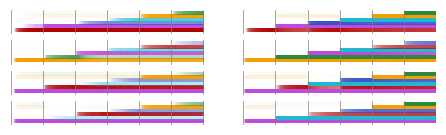

In [5]:
import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 6,})
fig, axes = plt.subplots(1, 2, figsize=(5.5, 1.5))
n_task = 6
y_gap = 3
n_ckpt = 601
task_order_list = ['PdAdPmAmPdmAdm', 'PdPmAdAmPdmAdm', 'PdmAdmPdAdPmAm', 'PmPdAmAdPdmAdm']
#########################
model_titles = ['OrthoWeightProj', 'ContextRNN']
save_name_fn0 = lambda task_order, seed: f'leakyrnn_v1_proj_relu_{task_order}_AdamWithProj_sd{seed}'
save_name_fn1 = lambda task_order, seed: f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_tskm512_sd{seed}'
##########################
# g1, g2 = 3, 10
# alpha = 0.2
# nonlin = 'relu'
# model_titles = [f'CxtG{g}A{int(alpha*10)}{nonlin}' for g in [g1, g2]]
# alpha_str = {0.1: '', 0.2: '_a0pt2'}[alpha]
# nonlin_str = {'tanh': '', 'relu': '_relu'}[nonlin]
# save_name_fn0 = lambda task_order, seed: f'cxtrnn_seq_v2_gating{g1}_ioZ{alpha_str}{nonlin_str}_{task_order}_tskm512_sd{seed}'
# save_name_fn1 = lambda task_order, seed: f'cxtrnn_seq_v2_gating{g2}_ioZ{alpha_str}{nonlin_str}_{task_order}_tskm512_sd{seed}'
##########################
for i_model, model_title in enumerate(model_titles):
    ax = axes[i_model]
    for i_order, task_order in enumerate(task_order_list):
        ts_arr_seeds = []
        for seed in range(5):
            if i_model == 0:
                save_name = save_name_fn0(task_order, seed)
            else:
                save_name = save_name_fn1(task_order, seed)
            if not os.path.isfile(f'./saved_models/{save_name}/config.json'):
                print(save_name)
                continue
            config = load_config(save_name)
            config['retrain'] = False
            if not os.path.isfile(f'./saved_models/{save_name}/ts_perf_strict.npy'):
                print(save_name)
                continue
            assert config['strict'] == True
            train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
            ts_arr_seeds.append(ts_perf_arr)
        ts_arr_seeds = np.array(ts_arr_seeds)
        ts_arr_avg = ts_arr_seeds.mean(0)
        for i_task, task_ts in enumerate(config['task_list']):
            plot_y = i_order * (n_task + y_gap) + i_task
            plot_arr = ts_arr_avg[i_task:(i_task + 1)]
            rgba = np.zeros((*plot_arr.shape, 4))
            rgba[..., :3] = mcolors.to_rgb(color_dict[task_ts])
            rgba[..., 3] = plot_arr ** 3  
            ax.imshow(rgba, aspect='auto', extent=[0, n_ckpt, plot_y, plot_y+1], origin='lower')
    print(model_title, sum(p.numel() for p in model.parameters() if p.requires_grad), flush=True)
    ymax = (len(task_order_list) - 1) * (n_task + y_gap) + n_task
    dn_ckpt = config['num_iter'] / config['ckpt_step']
    for ix in range(n_task + 1):
        for i_order in range(len(task_order_list)):
            plot_y = i_order * (n_task + y_gap)
            ax.plot([ix * dn_ckpt + 1] * 2, [plot_y - 0.5, plot_y + n_task + 0.5], color='gray', alpha=1, linewidth=0.5)
    ax.set_xlim(0 - 2, n_ckpt + 2)
    ax.set_ylim(0 - 0.6, ymax + 0.6)
    ax.axis('off')

save_sfx = '_'.join(model_titles)
fig_name = f'./figures/task_order_performance_{save_sfx}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

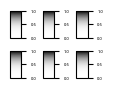

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.rcParams.update({'font.size': 3,})

n = 256
alpha_vals = np.linspace(0, 1, n) ** 3
bg_color = np.ones(3)  

fig, axes = plt.subplots(2, 3, figsize=(1, 1.75))
fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(wspace=2, hspace=0.5)

task_list = ['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M', 'PRO_DM', 'ANTI_DM']
for ax, task in zip(axes.flatten(), task_list):
    base_color = np.zeros(3) #'#np.array(mcolors.to_rgb(color_dict[task]))
    rgba_colors = [(1 - alpha) * bg_color + alpha * base_color for alpha in alpha_vals]
    cmap = ListedColormap(rgba_colors)
    sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=ax, orientation='vertical')
    # ax.axis('off')
    
fig_name = f'./figures/color_bar.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')
# Plot the colorbar

# Create a ScalarMappable with dummy normalization


# Add colorbar


### forward and backward transfer

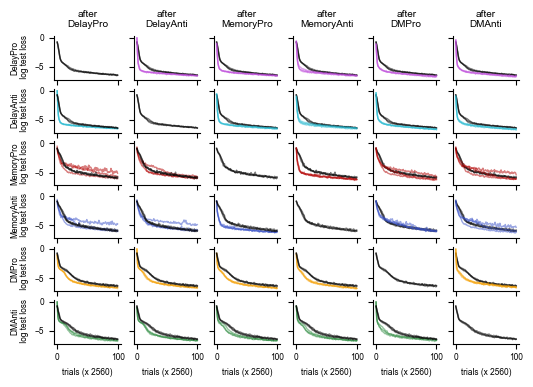

In [15]:
plt.rcParams.update({'font.size': 6,})
check_type = ['forward', 'backward'][0]
task_list_name_fn = lambda cur_task_list: ''.join([cur.split('_')[0][0] + cur.split('_')[1].lower() for cur in cur_task_list])
all_task_list = ['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M', 'PRO_DM', 'ANTI_DM']
nonlin_str = '_relu'
nitr_str = '' if check_type == 'forward' else '_nitr10'
sharey = True if check_type == 'forward' else 'row'
fig, axes = plt.subplots(6, 6, figsize=(6, 4), sharey=sharey, sharex=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
for itask1, task1 in enumerate(all_task_list):
    for itask2, task2 in enumerate(all_task_list):
        cur_task_list = [task1] if task1 == task2 else [task1, task2]
        cur_task_str = task_list_name_fn(cur_task_list)
        for seed in range(3):
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{cur_task_str}{nitr_str}_tskm512_sd{seed}'
            if not os.path.isfile(f'./saved_models/{save_name}/model.pth'):
                print(save_name)
                continue
            config = load_config(save_name)
            config['retrain'] = False
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_cxtrnn_sequential(**config)
            
            ii = 1 if check_type == 'forward' else 0
            color = color_dict[[task1, task2][ii]] if len(config['task_list']) > 1 else 'k'
            kwargs = dict(color=color, alpha=0.5, linewidth=1)
            plot_y = np.log(ts_loss_arr)
            n_ckpt = int(config['num_iter'] / config['ckpt_step'])
            if itask1 == itask2 and check_type == 'forward':
                plot_y = plot_y[0]
                for ax in axes[[itask1, itask2][ii], :]:
                    ax.plot(plot_y, **kwargs)
            else:
                if check_type == 'forward':
                    plot_y = plot_y[ii][n_ckpt:]
                else:
                    plot_y = plot_y[ii][n_ckpt:]
                axes[[itask1, itask2][ii], [itask1, itask2][1 - ii]].plot(plot_y, **kwargs)
            
for itask, task in enumerate(all_task_list):
    task_label = label_dict[task]
    axes[itask, 0].set_ylabel(task_label + '\n log test loss')
    if check_type == 'forward':
        axes[0, itask].set_title('after\n' + task_label)
    else:
        axes[0, itask].set_title('during\n' + task_label)
    
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False)
for ax in axes[-1]:
    ax.set_xlabel('trials (x {})'.format(int(256 * config['ckpt_step'])))
fig_name = f'./figures/{check_type}_transfer{nitr_str}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### forward transfer example

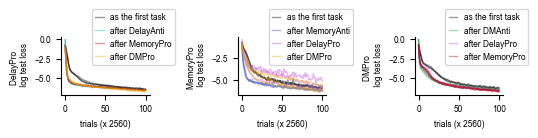

In [6]:
plt.rcParams.update({'font.size': 6,})
task_list_name_fn = lambda cur_task_list: ''.join([cur.split('_')[0][0] + cur.split('_')[1].lower() for cur in cur_task_list])
nonlin_str = '_relu'
task2_list = ['PRO_D', 'PRO_M', 'PRO_DM']
fig, axes = plt.subplots(1, len(task2_list), figsize=(1.9 * len(task2_list), 0.75))
fig.subplots_adjust(wspace=1, hspace=0.2)
for task2, ax in zip(task2_list, axes):
    task1_list = [task2, task2.replace('PRO', 'ANTI')] + [task1 for task1 in ['PRO_D', 'PRO_M', 'PRO_DM'] if task1 != task2]
    for task1 in task1_list:
        cur_task_list = [task1] if task1 == task2 else [task1, task2]
        cur_task_str = task_list_name_fn(cur_task_list)
        for seed in range(3):
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{cur_task_str}_tskm512_sd{seed}'
            config = load_config(save_name)
            config['retrain'] = False
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_cxtrnn_sequential(**config)
            n_ckpt = int(config['num_iter'] / config['ckpt_step'])
            plot_y = np.log(ts_loss_arr)
            plot_y = plot_y[0] if task1 == task2 else plot_y[1][n_ckpt:]
            color = color_dict[task1] if len(config['task_list']) > 1 else 'k'
            label = f'after {label_dict[task1]}' if len(config['task_list']) > 1 else 'as the first task'
            label_kwargs = {} if seed != 0 else dict(label=label)
            ax.plot(plot_y, color=color, alpha=0.4, linewidth=1, **label_kwargs)
    ax.legend(loc='center left', bbox_to_anchor=(0.3, 1), handlelength=1)
    ax.set_ylabel(f'{label_dict[task2]} \n log test loss')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('trials (x {})'.format(int(config['batch_size'] * config['ckpt_step'])))
fig_name = f'./figures/forward_transfer_example.png'
fig.savefig(fig_name, bbox_inches='tight', transparent=True)
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight', transparent=True)

### backward transfer example

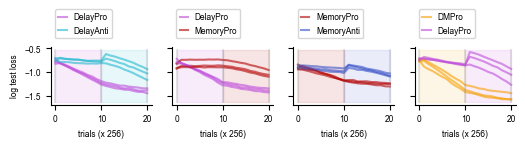

In [4]:
plt.rcParams.update({'font.size': 6,})
task_order_list = ['PdAd', 'PdPm', 'PmAm', 'PdmPd']
fig, axes = plt.subplots(1, len(task_order_list), figsize=(1.5 * len(task_order_list), 0.75),
                         sharex=True, sharey=True)
#########################
save_name_fn = lambda task_order, seed: f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_nitr10_tskm512_sd{seed}'
save_sfx = ''
#########################
# nonlin_str = ['_relu', ''][0]
# nitr = 15
# save_name_fn = lambda task_order, seed: f'leakyrnn_v1_proj{nonlin_str}_{task_order}_nitr{nitr}_AdamWithProj_sd{seed}'
# save_sfx = f'_owp{nonlin_str}_nitr{nitr}'
#########################
for task_order, ax in zip(task_order_list, axes):
    for seed in range(3):
        save_name = save_name_fn(task_order, seed)
        if not os.path.isfile(f'./saved_models/{save_name}/model.pth'):
            print(save_name)
            continue
        config = load_config(save_name)
        config['retrain'] = False
        train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
        model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
        ts_arr = np.log(ts_loss_arr)
        for itask, task_ts in enumerate(config['task_list']):
            label_kwargs = {'label': label_dict[task_ts]} if seed == 0 else {}
            ax.plot(ts_arr[itask], color=color_dict[task_ts], alpha=0.6, **label_kwargs)
ymin, ymax = axes[0].get_ylim()
for task_order, ax in zip(task_order_list, axes):
    save_name = save_name_fn(task_order, 0)
    config = load_config(save_name)
    dn_ckpt = config['num_iter'] / config['ckpt_step']
    for itask in range(len(config['task_list']) + 1):
        ax.plot([itask * dn_ckpt] * 2, [ymin, ymax], alpha=0.2, color='gray')
    for itask, task_ts in enumerate(config['task_list']):
        ax.fill_between([itask * dn_ckpt, (itask + 1) * dn_ckpt], ymin, ymax, 
                         color=color_dict[task_ts], alpha=0.1)
    ax.set_xlabel('trials (x {})'.format(config['batch_size']))
axes[0].set_ylabel('log test loss')
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(0, 1.4), handlelength=1)
    ax.spines[['top', 'right']].set_visible(False)   
if 'leakyrnn_v1_proj_relu' in save_name:
    axes[0].set_ylim(ymin, 0)
fig_name = f'./figures/backward_transfer_example{save_sfx}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### few shot learning

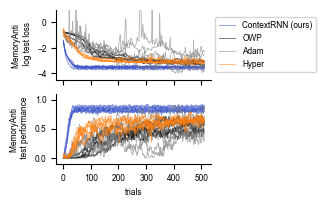

In [5]:
plt.rcParams.update({'font.size': 6,})
task_order = 'PsAsPm'
new_task = 'ANTI_M'
fig, axes = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
n_model = 4
ts_perf_collect = [[] for i_model in range(n_model)]
for i_model in range(n_model):
    for seed in range(5):
        if i_model == 0: 
            save_name = f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_tskm512_sd{seed}'
            color = color_dict[new_task]
            label = 'ContextRNN (ours)'
            save_sfx = ''
        elif i_model == 1:
            save_name = f'leakyrnn_v1_proj_relu_{task_order}Am_AdamWithProj_sd{seed}' 
            color = 'k'
            label = 'OWP'
            save_sfx = ''
        elif i_model == 2:
            color = 'gray'
            label = 'Adam'
            save_name = f'leakyrnn_v1_relu_{task_order}Am_AdamWithProj_sd{seed}'
            save_sfx = ''
            # save_name = f'leakyrnn_v1_proj_relu_{task_order}Am_AdamWithProj_sd{seed}'
            # save_sfx = '_INIT'  # not using owp and not loading trained model
        elif i_model == 3:
            save_name = f'hyperrnn_v1_relu_sumbeta1_{task_order}Am_lr0pt001_sd{seed}'
            color = 'C1'
            label = 'Hyper'
            save_sfx = ''
        else:
            save_name = f'hyperrnn_v1_relu_sumbeta1_{task_order}Am_lr0pt001_sd{seed}'
            color = 'C2'
            label = 'HyperINIT'
            save_sfx = '_INIT' # train from scratch
        config = load_config(save_name)
        config['retrain'] = False
        ts_loss_arr = np.load(f'./saved_models/{save_name}/ts_loss_few_shot{save_sfx}.npy')
        ts_perf_arr = np.load(f'./saved_models/{save_name}/ts_perf_few_shot{save_sfx}.npy')
        ts_err_file = f'./saved_models/{save_name}/ts_err_few_shot{save_sfx}.npy'
        ts_err_arr = np.load(ts_err_file) if os.path.isfile(ts_err_file) else np.zeros(ts_loss_arr.shape)
        task_list = (config['task_list'] + [new_task]) if len(config['task_list']) == 3 else config['task_list']
        itask = task_list.index(new_task)
        for iax, plot_arr in enumerate([np.log(ts_loss_arr), ts_perf_arr]):
            lbl_kwargs = dict(label=label) if seed == 0 else {}
            axes[iax].plot(plot_arr[:512, itask], color=color, alpha=0.6, linewidth=0.6, **lbl_kwargs)
        ts_perf_collect[i_model].append(ts_perf_arr)
axes[0].set_ylabel('MemoryAnti \n log test loss')
axes[1].set_ylabel('MemoryAnti \n test performance')
axes[1].set_xlabel('trials')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim([-4.5, 1])
axes[1].set_ylim([0-0.1, 1+0.1])
for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
fig_name = f'./figures/few_shot_example_{task_order}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

In [6]:
# n_model x n_seed x n_trial (513) x n_task (4)
ts_perf_collect = np.array(ts_perf_collect)
# n_model x n_trial
ts_arr_avg = ts_perf_collect.mean(1)[..., -1] 
ts_arr_std = ts_perf_collect.std(1)[..., -1]
itrials = [0, 20, 40, 512]
for i_model in [0, 1, 2, 3]: # 'ContextRNN', 'OWP', , 'Adam', 'Hyper'
    cur_str = [f"{ts_arr_avg[i_model, itrial]:.2f} (± {ts_arr_std[i_model, itrial]:.2f})" for itrial in itrials]
    cur_str = ' & '.join(cur_str)
    print(cur_str)

0.00 (± 0.00) & 0.56 (± 0.06) & 0.83 (± 0.02) & 0.83 (± 0.04)
0.00 (± 0.00) & 0.00 (± 0.01) & 0.01 (± 0.02) & 0.53 (± 0.09)
0.00 (± 0.00) & 0.05 (± 0.03) & 0.10 (± 0.07) & 0.56 (± 0.19)
0.00 (± 0.00) & 0.03 (± 0.02) & 0.19 (± 0.05) & 0.64 (± 0.03)
